In [45]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from processing.postprocessing import train_test_df_split, train_test_handling
from models.lstm import LSTM

In [2]:
df = pd.read_csv('subject_10.csv')

In [3]:
%%time
train_df, test_df = train_test_df_split(df, 4)

CPU times: user 234 ms, sys: 4.79 ms, total: 238 ms
Wall time: 238 ms


In [4]:
X_train, y_train, train_trials, train_type, \
    X_val, y_val, val_trials, val_type = train_test_handling(train_df, test_df)

In [18]:
model = LSTM(
    window_size=20,
    hidden_size=96,
    batch_size=2,
    output_size=2
)

model.init_data(X_train, y_train, X_val, y_val)

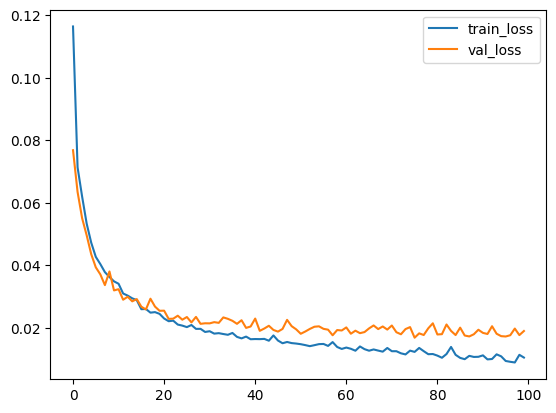

In [19]:
model.train(verbose=True)

In [20]:
import torch

window_size = 20
X_val = X_val.reshape(-1, window_size, 8)
y_val = y_val.reshape(-1, window_size, 2)

val_data = torch.FloatTensor(X_val)
val_pred = torch.FloatTensor(y_val)
val_loader = model.create_dataloader(val_data, val_pred, batch_size=10, shuffle=False)

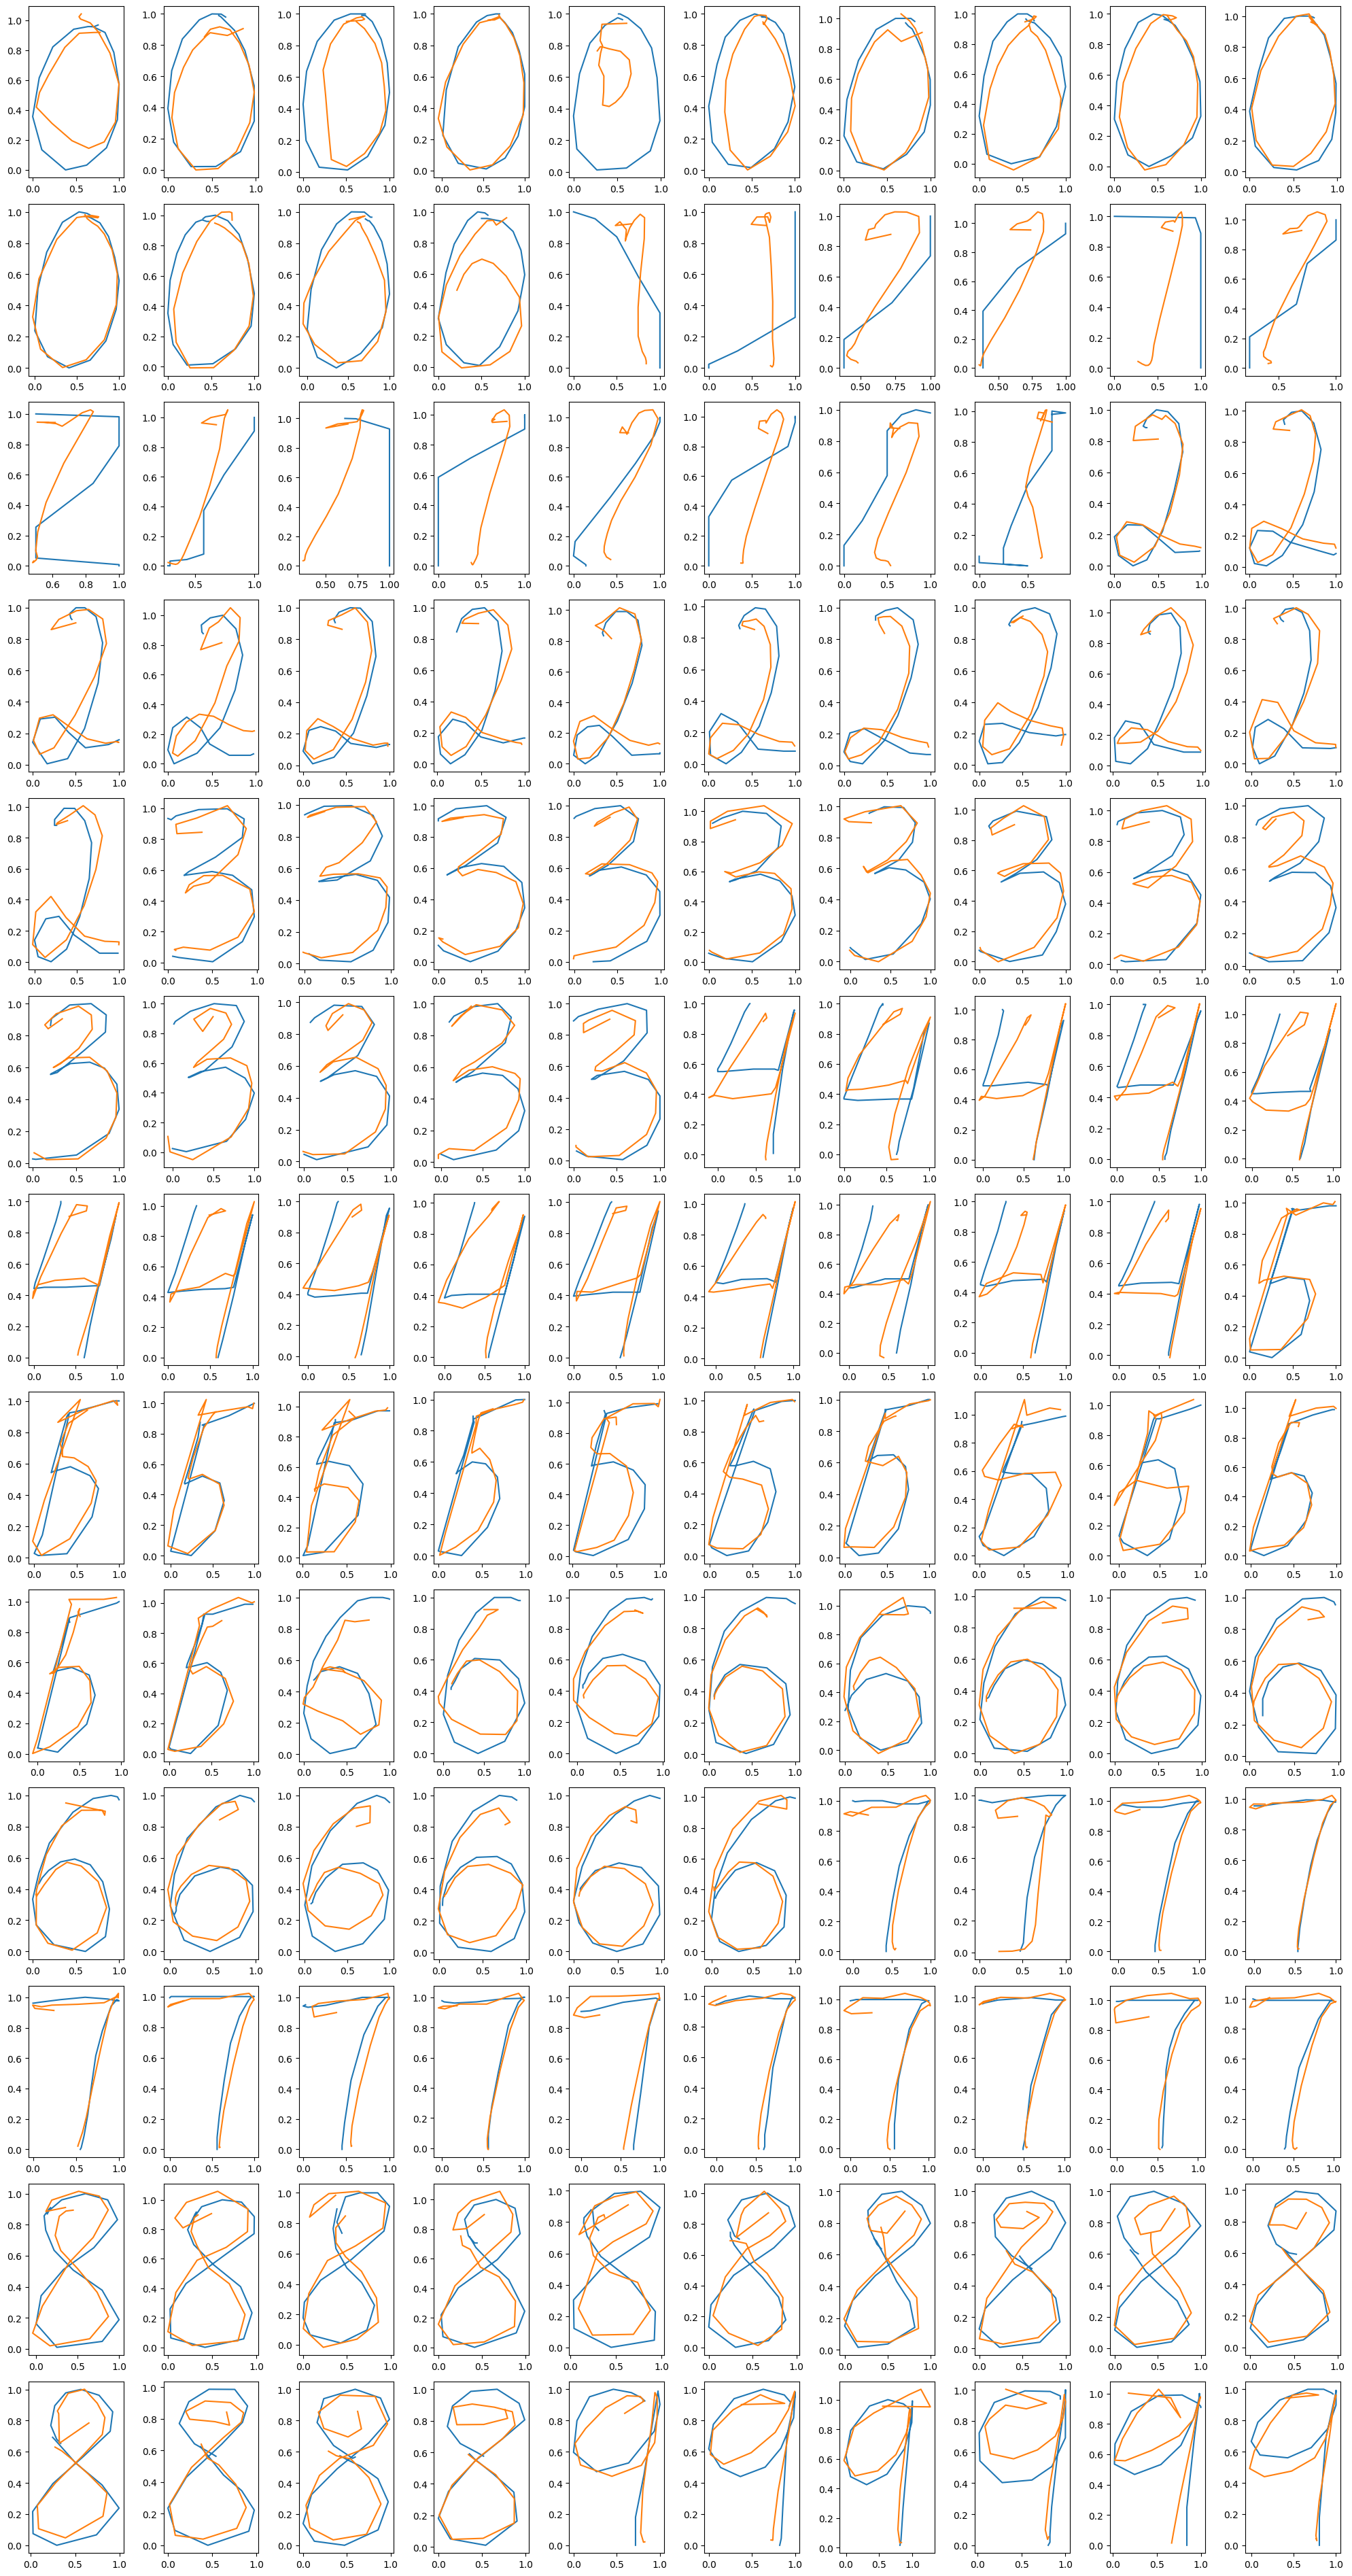

In [21]:
fig, ax = plt.subplots(len(val_loader), 10, figsize=(20, 38))
for i, (X_batch, y_batch) in enumerate(val_loader):
    preds = model.predict(X_batch)
    preds = preds.detach()

    for j, pred in enumerate(preds):
        ax[i, j].plot(y_batch[j, :, 0], y_batch[j, :, 1])
        ax[i, j].plot(pred[:, 0], pred[:, 1])
plt.tight_layout()
plt.savefig("result_lstm.png", dpi=125)

In [32]:
len(val_type[::20])

137

In [33]:
len(val_loader)

13

In [41]:
preds.shape

torch.Size([1, 20, 2])

In [42]:
preds.shape, len(val_loader)

(torch.Size([1, 20, 2]), 137)

In [36]:
val_loader = model.create_dataloader(val_data, val_pred, batch_size=1, shuffle=False)

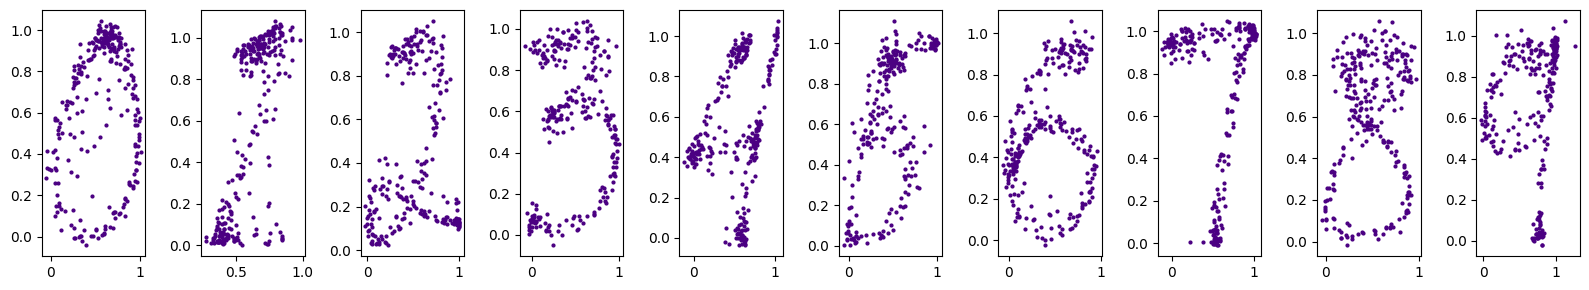

In [62]:
fig, ax = plt.subplots(1, 10, figsize=(16, 3))

index = 0
curr_index = 0

type_check = val_type[::20]

prev_type = 1

for i, (X_batch, y_batch) in enumerate(val_loader):
    if type_check[i] != prev_type:
        index += 1
        prev_type = type_check[i]
    preds = model.predict(X_batch)
    preds = preds.detach()

    # ax[index].plot(y_batch[0, :, 0], y_batch[0, :, 1])
    ax[index].scatter(preds[0, :, 0], preds[0, :, 1], c='indigo', s=4)

    # if val_type[] != val_type[curr_index]:
    #     index += 1
plt.tight_layout()
plt.savefig("result_lstm.png", dpi=125)